In [1]:
import tensorflow as tf
import numpy as np
import mediapipe as mp
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from tqdm import tqdm
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import cv2

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:
def detect_and_crop_eye_region(image):
    # gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image.astype(np.uint8)

    # if len(image.shape) == 2:
    #     print("Image is in grayscale format (CV_8U)")
    # elif len(image.shape) == 3:
    #     print("Image is in color format (CV_8UC3)")
    #     print(image.shape)
    #     # If you want to check if the image is in BGR or RGB format
    #     if image.shape[2] == 3:
    #         print("Image is in BGR color format")
    #     elif image.shape[2] == 4:
    #         print("Image is in RGBA color format")
    # else:
    #     print("Unknown image format")

    # # Detect faces using Haarcascade
    # faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    try:
        for i in range(30):
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            results = face_mesh.process(image_rgb)
            if results.multi_face_landmarks:
                # print('face found')
                # Extract the first face landmarks (assuming only one face per image)
                face_landmarks = results.multi_face_landmarks[0]

                # Extract landmark points
                landmark_points = [(lm.x * image.shape[1], lm.y * image.shape[0]) for lm in face_landmarks.landmark]

                # Convert the landmark points to NumPy array
                landmark_points = np.array(landmark_points)

                # Extract eyes region
                eyes_roi = image[min(int(landmark_points[67, 1]), int(landmark_points[10, 1]), int(landmark_points[297, 1])):max(int(landmark_points[118, 1]),int(landmark_points[346, 1])),
                            int(landmark_points[162, 0]):int(landmark_points[389, 0])]

                mouth_roi = image[int(landmark_points[4, 1]):int(landmark_points[200, 1]),
                            int(landmark_points[132, 0]):int(landmark_points[361, 0])]

                # print("Size of eyes_roi before resize:", eyes_roi.shape)
                # if len(eyes_roi) > 0:
                #     eyes_roi = cv2.resize(eyes_roi, (144, 50))
                #     print("Size of eyes_roi after resize:", eyes_roi.shape)
                # else:
                #     print("Eyes region is empty. Skipping resizing.")
                # print("Size of mouth before resize:", mouth_roi.shape)
                # if len(mouth_roi) > 0:
                #     eyes_roi = cv2.resize(eyes_roi, (144, 50))
                #     print("Size of mouth_roi after resize:", eyes_roi.shape)
                # else:
                #     print("Eyes region is empty. Skipping resizing.")

                # Resize eyes and mouth regions to a fixed size (adjust as needed)

                eyes_roi = cv2.resize(eyes_roi, (48, 26))
                mouth_roi = cv2.resize(mouth_roi, (48, 22))

                # Combine individual ROIs into a single image
                combined_image = np.vstack((eyes_roi, mouth_roi))

                # Resize the combined image to the desired size (adjust as needed)
                combined_image = cv2.resize(combined_image, (48, 48))
                # combined_image = cv2.cvtColor(face_region, cv2.COLOR_BGR2GRAY)

                return combined_image
                # else:
                #     return None
        return None
    except cv2.error as e:
        # print("Error extracting roi:")
        return None

def preprocess_data():
    data = pd.read_csv('../Dataset/fer2013/fer2013.csv')
    labels = pd.read_csv('../Dataset/fer2013/fer2013new.csv')

    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    n_samples = len(data)
    w = 48
    h = 48

    X = np.zeros((n_samples, w, h, 1))


    new_pixel_values = []
    count = 0

    for i in range(n_samples):
        X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

    # Extract and save eye regions
    for i in tqdm(range(n_samples), desc='Processing images', unit='image'):
        img = X[i].reshape((48, 48, 1))

        # tqdm.write(f'Processing image {i + 1}/{n_samples}', end='\r')
        # print(img)
        extracted_image = detect_and_crop_eye_region(img)

        if extracted_image is not None:
            count += 1
            pixel_values = extracted_image.tobytes()
            new_pixel_values.append(pixel_values)

        else:
            new_pixel_values.append(None)

    data['pixels'] = new_pixel_values

    # Get the indices of rows with non-empty pixel values
    non_empty_indices = data.index[data['pixels'].notnull()]
    print(non_empty_indices)

    # Filter labels dataframe based on non-empty pixel values indices
    labels = labels.iloc[non_empty_indices]

    print(len(labels))

    # Drop rows where the pixel values column has empty strings
    data.dropna(subset=['pixels'], inplace=True)

    # Reset index after dropping rows
    data.reset_index(drop=True, inplace=True)

    data.to_csv('new_data.csv', index=False)

    print('Extracted images count: ', count)

    n_samples = len(data)  
    X1 = np.zeros((n_samples, 48, 48, 1))

    for i in range(n_samples):
        # X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((w, h, 1))
        img_array_loaded = np.frombuffer(data['pixels'][i], dtype=np.uint8)
        X1[i] = img_array_loaded.reshape((48, 48, 1))

    y = np.array(labels[orig_class_names])

    return X1, y



def clean_and_normalize_data(X, y):
    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    # Using mask to remove unknown and NF images
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('unknown')
    X = X[mask]
    y = y[mask]

    #Add contempt to neutral and remove it
    y[:, 0] += y[:, 7]
    y = y[:, :7]

    # Using mask to remove disgust and fear images
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('disgust')
    X = X[mask]
    y = y[mask]

    # Convert to probabilities between 0 and 1
    y = y[:, :-2] * 0.1

    # Normalize image vectors
    X = X / 255.0

    return X, y


def split_data(X, y):
    test_size = ceil(len(X) * 0.1)

    # Split Data
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size,
                                                                      random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test


def data_augmentation(x_train):
    datagen = ImageDataGenerator()
    datagen.fit(x_train)
    return datagen


def graphs(history):
    #Accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    #Loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()


def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


def model():
    model = tf.keras.Sequential()

    model.add(kl.InputLayer(input_shape=(48, 48, 1)))
    # First conv block
    model.add(kl.Conv2D(filters=128, kernel_size=3, padding='same', strides=2))
    model.add(kl.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.4))
    # Second conv block
    model.add(kl.Conv2D(filters=256, kernel_size=3, padding='same', strides=2))
    model.add(kl.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.4))
    # Third conv block
    model.add(kl.Conv2D(filters=512, kernel_size=3, padding='same', strides=2))
    model.add(kl.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.4))
    # Flatten
    model.add(kl.Flatten())
    
    # First FC
    model.add(kl.Dense(1024))
    # Second Fc
    model.add(kl.Dense(512))
    # Output FC with sigmoid at the end
    model.add(kl.Dense(5, activation='softmax', name='prediction'))
    
    # model = tf.keras.Sequential()
    # model.add(kl.InputLayer(input_shape=(48, 48, 1)))
    # 
    # # Convolutional layers with increased filters and kernel size
    # model.add(kl.Conv2D(filters=128, kernel_size=3, padding='same',strides=2))
    # model.add(kl.BatchNormalization())
    # model.add(tf.keras.layers.ReLU())
    # model.add(kl.Conv2D(filters=128, kernel_size=3, padding='same',strides=2))
    # model.add(kl.BatchNormalization())
    # model.add(tf.keras.layers.ReLU())
    # model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    # model.add(kl.Dropout(0.4))
    # 
    # model.add(kl.Conv2D(filters=256, kernel_size=3, padding='same',strides=2))
    # model.add(kl.BatchNormalization())
    # model.add(tf.keras.layers.ReLU())
    # # model.add(kl.Conv2D(filters=256, kernel_size=3, padding='same',strides=2))
    # # model.add(kl.BatchNormalization())
    # # model.add(tf.keras.layers.ReLU())
    # # model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    # model.add(kl.Dropout(0.4))
    # 
    # model.add(kl.Conv2D(filters=512, kernel_size=3, padding='same',strides=2))
    # model.add(kl.BatchNormalization())
    # model.add(tf.keras.layers.ReLU())
    # # model.add(kl.Conv2D(filters=512, kernel_size=3, padding='same',strides=2))
    # # model.add(kl.BatchNormalization())
    # # model.add(tf.keras.layers.ReLU())
    # # model.add(kl.MaxPooling2D(pool_size=(1, 1)))
    # model.add(kl.Dropout(0.4))
    # 
    # # model.add(kl.Conv2D(filters=1024, kernel_size=3, padding='same',strides=2))
    # # model.add(kl.BatchNormalization())
    # # model.add(tf.keras.layers.ReLU())
    # # model.add(kl.MaxPooling2D(pool_size=(1, 1)))
    # # model.add(kl.Dropout(0.4))
    # 
    # # Flatten and fully connected layers with increased neurons
    # model.add(kl.Flatten())
    # model.add(kl.Dense(1024))
    # model.add(kl.BatchNormalization())
    # model.add(tf.keras.layers.ReLU())
    # model.add(kl.Dropout(0.5))
    # 
    # model.add(kl.Dense(512))
    # model.add(kl.BatchNormalization())
    # model.add(tf.keras.layers.ReLU())
    # model.add(kl.Dropout(0.5))
    # 
    # # Output layer with softmax activation
    # model.add(kl.Dense(5, activation='softmax', name='prediction'))

    return model


def saveModelWeights(model, test_acc):
    # Serialize and save model to JSON
    model_name = f'basic_emotion_model_{test_acc:.4f}'
    model_json = model.to_json()
    with open(f'{model_name}.json', 'w') as json_file:
        json_file.write(model_json)
    # Save weights to JSON
    model.save_weights(f'{model_name}.h5')


In [5]:
fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger']

X, y = preprocess_data()
X, y = clean_and_normalize_data(X, y)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)
datagen = data_augmentation(x_train)

Processing images: 100%|██████████| 35887/35887 [04:19<00:00, 138.56image/s]


Index([    1,     2,     4,     5,     7,     8,     9,    10,    11,    12,
       ...
       35877, 35878, 35879, 35880, 35881, 35882, 35883, 35884, 35885, 35886],
      dtype='int64', length=30230)
30230
Extracted images count:  30230


In [107]:
# n_samples = len(data)
# w = 56
# h = 80
# 
# # Get the indices of rows with non-empty pixel values
# non_empty_indices = data.index[data['pixels'].notna()]
# 
# # Filter labels dataframe based on non-empty pixel values indices
# labels = labels.iloc[non_empty_indices]
# 
# # Drop rows where the pixel values column has empty strings
# data.dropna(subset=['pixels'], inplace=True)
# 
# # Reset index after dropping rows
# data.reset_index(drop=True, inplace=True)
# 
# data.to_csv('new_data.csv', index=False)
# 
# print('Extracted images count: ', count)
# 
# # n_samples = len(data)  
# # X1 = np.zeros((n_samples, 56, 80, 1))
# # 
# # for i in range(n_samples):
# #     # X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((w, h, 1))
# #     img_array_loaded = np.frombuffer(data['pixels'][i], dtype=np.uint8)
# #     X1[i] = img_array_loaded.reshape((56, 80, 1))
#     
# orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
#                         'unknown', 'NF']
# 
# y = np.array(labels[orig_class_names])
# 
# X, y = clean_and_normalize_data(X1, y)
# x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)
# datagen = data_augmentation(x_train)

In [12]:
epochs = 100
batch_size = 64

earlyStopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True
)

lrScheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

callbacks = [
    earlyStopping,
    lrScheduler,
]

# print(x_train)

model = model()
model.summary()
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# print(x_train[0].shape)

# plt.imshow(x_train[0])
# plt.title('Combined Image')
# plt.axis('off')
# plt.show()

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val), verbose=2,
                    callbacks=callbacks)

ValueError: Exception encountered when calling layer "max_pooling2d_11" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_11/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,3,1,256].

Call arguments received by layer "max_pooling2d_11" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 3, 1, 256), dtype=float32)

46/46 [==============================] - 1s 15ms/step - loss: 0.2781 - accuracy: 0.7631


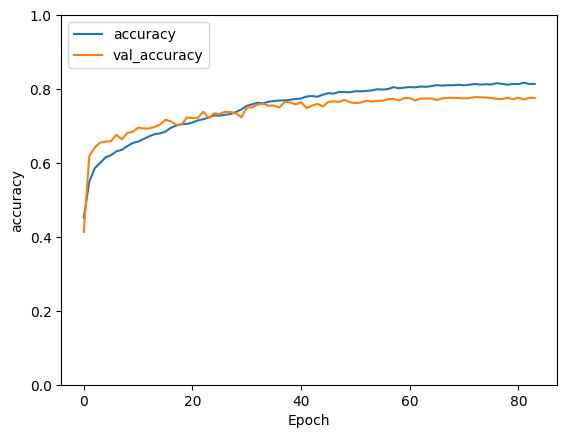

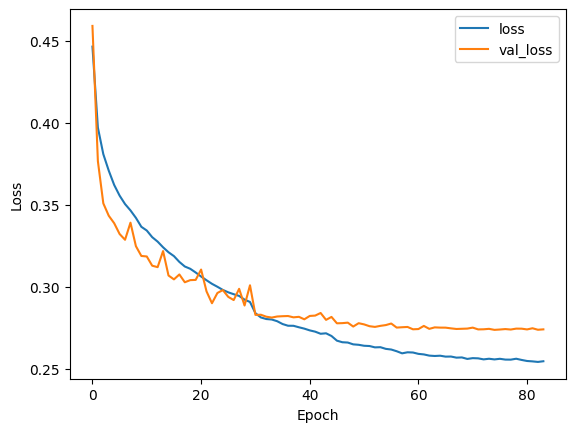

In [110]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

graphs(history)

saveModelWeights(model, test_acc)

92/92 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

     neutral       0.74      0.87      0.80      1142
   happiness       0.81      0.86      0.84       844
    surprise       0.79      0.76      0.78       376
     sadness       0.58      0.36      0.44       312
       anger       0.82      0.45      0.58       239

    accuracy                           0.76      2913
   macro avg       0.75      0.66      0.69      2913
weighted avg       0.76      0.76      0.75      2913


/var/folders/wx/c2fc49pd4s7fq23msz0ypksh0000gn/T/ipykernel_3368/3669170031.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


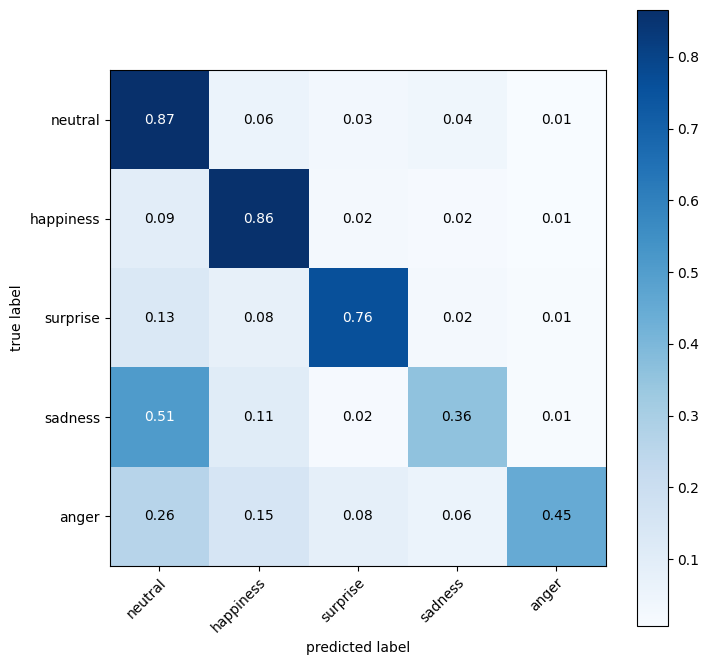

In [122]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

pred_test_labels = model.predict(x_test)

conf_mat = confusion_matrix(y_test.argmax(axis=1), pred_test_labels.argmax(axis=1))

emotions = {0: 'neutral', 1: 'happiness', 2: 'surprise', 3: 'sadness', 4: 'anger'}

#Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()
#Print classifation report
print(classification_report(y_test.argmax(axis=1), pred_test_labels.argmax(axis=1), target_names=emotions.values()))